# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [1]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
project_path = '/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/External Lab/'

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path+'train/'   #Path for your train data

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [5]:
!mkdir '/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/External Lab/train'

mkdir: cannot create directory ‘/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/External Lab/train’: File exists


# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall(path_train)


In [0]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [8]:
import os
os.listdir(path_train)

['images', 'masks']

In [0]:
imagelist = os.listdir(path_train+'images')
masklist = os.listdir(path_train+'masks')

In [10]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[3999])

2578042000.png
d4d2ed6bd2.png
4b522e501e.png
d4d2ed6bd2.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


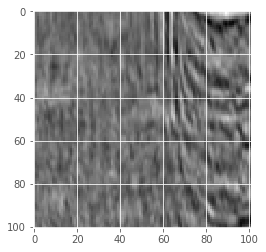

In [11]:
import matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread(path_train+'images/7cc53fe88b.png'))



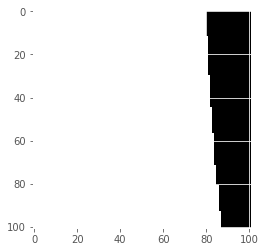

In [12]:
plt.imshow(cv2.imread(path_train+'masks/7cc53fe88b.png'))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [13]:
X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32)
y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
X.shape

(4000, 128, 128, 1)

In [14]:
len(masklist)

4000

In [0]:
from  PIL import Image
for n in imagelist: 
  k = imagelist.index(n)
  image_path =  os.path.join(path_train+'images/',n)
  resized_img = Image.open(image_path)
  #img.resize resizes the to the new shape and replaces any extra pixels with 0 whereas np.resize again repeats the array values
  resized_img = resized_img.resize((im_width, im_height))
  #reshape is used to change the structure of an existing array and not change the size of the array overall (eg) (128*128*1 = 128*128)                       
  #also image needs to be converted to numpy array before reshaping so resized_img.convert is used
  resized_img = np.reshape(resized_img.convert('L'), (128,128,1))
  X[k] = resized_img
                

In [0]:

for n in imagelist: 
  k = masklist.index(n)
  image_path =  os.path.join(path_train+'masks/',n)
  resized_mask = Image.open(image_path)
  #img.resize resizes the to the new shape and replaces any extra pixels with 0 whereas np.resize again repeats the array values
  resized_mask = resized_mask.resize((im_width, im_height))
  #reshape is used to change the structure of an existing array and not change the size of the array overall (eg) (128*128*1 = 128*128)                       
  #also image needs to be converted to numpy array before reshaping so resized_img.convert is used
  resized_mask = np.reshape(resized_mask.convert('L'), (128,128,1))
  y[k] = resized_mask

In [17]:
# Get and resize train images and masks
def get_data():
    
    for n in imagelist: 
        k = imagelist.index(n)
        
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask/255
    print('Done!')
    return X, y
    
X, y = get_data()

Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [19]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)


(3400, 128, 128, 1) (3400, 128, 128, 1) (600, 128, 128, 1) (600, 128, 128, 1)


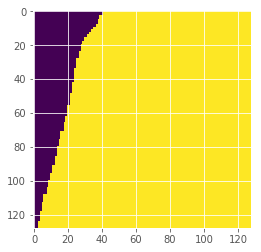

In [20]:
plt.imshow(y_train[40].squeeze())

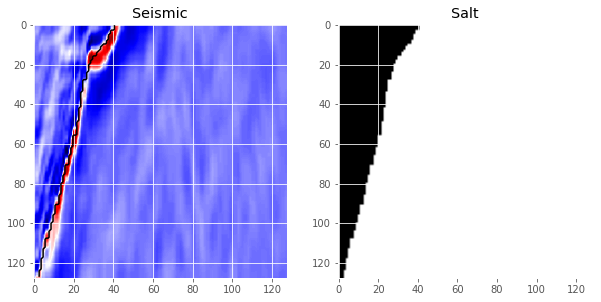

In [21]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




### 8. Define loss and dice_coeff function.

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [24]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-r_s62c8j
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-r_s62c8j
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.0b1-cp36-none-any.whl size=33612 sha256=ebf8c38007b3adbbdd366e2eeb2fb328313fa9a999a749d3b1185ba893a82a28
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pirx828/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-cp36-none-any.whl size=19955 sha256=3c1cbc2748ed3509243f743a2335e11524886f031e53d4f19c4f1172b3d8c2e8
  Stored in directory: /root/.cache/pip/wheels/a4/22/b6/715c09496e4a64024b00a695e07a2b5804286f4840852fbcd3
  Created wheel for efficientnet: filename=efficientnet-1.0.0b3-cp36-none-any.whl size=13401 sha256=81a5878f9b65148be0df1fc6d966035b89c009493cc6693418b9e7f0f610

In [25]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [0]:
#Build and compile Unet model

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)

In [0]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from segmentation_models import Unet

In [29]:


base_model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None,None, 1))
inp = Input(shape=(128, 128, 1))
l1 = Conv2D(1, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)
model = Model(inp, out, name=base_model.name)
#compile your model by adding the parameters like optimizer, loss and metrics.
# compile model
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [30]:
#Get the summary of your model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 1)       2         
_________________________________________________________________
model_2 (Model)              multiple                  24449876  
Total params: 24,449,878
Trainable params: 24,432,532
Non-trainable params: 17,346
_________________________________________________________________


### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [31]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,    
    epochs=20,
    validation_data=(x_val, y_valid)
)

Train on 3400 samples, validate on 600 samples
Epoch 1/20
3400/3400 [==============================] - 61s 18ms/step - loss: 0.0967 - dice_coefficient: 0.9665 - val_loss: 0.0257 - val_dice_coefficient: 0.9920
Epoch 2/20
3400/3400 [==============================] - 46s 14ms/step - loss: 0.0077 - dice_coefficient: 0.9972 - val_loss: 0.0075 - val_dice_coefficient: 0.9972
Epoch 3/20
3400/3400 [==============================] - 46s 13ms/step - loss: 0.0032 - dice_coefficient: 0.9988 - val_loss: 0.0039 - val_dice_coefficient: 0.9986
Epoch 4/20
3400/3400 [==============================] - 46s 13ms/step - loss: 0.0018 - dice_coefficient: 0.9993 - val_loss: 0.0023 - val_dice_coefficient: 0.9992
Epoch 5/20
3400/3400 [==============================] - 46s 13ms/step - loss: 0.0011 - dice_coefficient: 0.9996 - val_loss: 0.0013 - val_dice_coefficient: 0.9995
Epoch 6/20
3400/3400 [==============================] - 46s 13ms/step - loss: 7.9908e-04 - dice_coefficient: 0.9997 - val_loss: 9.0490e-04 - va

### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

In [0]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [32]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Import Keras and other libraries

In [0]:
from keras.preprocessing.text import Tokenizer
import glob

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM,GRU, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:

project_path = '/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/External Lab/textdata/data'

In [0]:
textlist = os.listdir(project_path)

In [38]:
textlist[0:1]

['The Happy Prince and other tales.txt']

In [39]:
textlist

['The Happy Prince and other tales.txt',
 'The Ballad of Reading Gaol.txt',
 'Selected prose of oscar wilde with a Preface by Robert Ross.txt',
 'Vera or, The Nihilists.txt',
 'The Soul of Man.txt',
 'The Duchess of Padua.txt',
 'Shorter Prose Pieces.txt',
 'The Canterville Ghost.txt',
 'The Importance of Being Earnest.txt',
 'The Picture of Dorian Gray.txt']

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
os.chdir(project_path)
textLst = []
for txtFile in textlist:
  f = open(txtFile, "r")
  textLst.append(f.read())

In [41]:
textLst[0]

'\ufeffThe Project Gutenberg eBook, The Happy Prince, by Oscar Wilde, Illustrated\nby Walter Crane\n\n\nThis eBook is for the use of anyone anywhere in the United States and most\nother parts of the world at no cost and with almost no restrictions \nwhatsoever.  You may copy it, give it away or re-use it under the terms of\nthe Project Gutenberg License included with this eBook or online at \nwww.gutenberg.org.  If you are not located in the United States, you\'ll have\nto check the laws of the country where you are located before using this ebook.\n\n\n\n\nTitle: The Happy Prince\n       and Other Tales\n\n\nAuthor: Oscar Wilde\n\n\n\nRelease Date: March 29, 2015  [eBook #902]\n[This file was first posted on May 6, 1997]\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\n\n***START OF THE PROJECT GUTENBERG EBOOK THE HAPPY PRINCE***\n\n\nTranscribed from the 1910 David Nutt edition by David Price, email\nccx074@pglaf.org.  Second proof by Paul Redmond.\n\n                        

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(textLst)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

In [44]:
word_idx

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'a': 5,
 'i': 6,
 'in': 7,
 'you': 8,
 'is': 9,
 'that': 10,
 'it': 11,
 'he': 12,
 'with': 13,
 'his': 14,
 'for': 15,
 'was': 16,
 'not': 17,
 'have': 18,
 'as': 19,
 'be': 20,
 'at': 21,
 'are': 22,
 'or': 23,
 'had': 24,
 'but': 25,
 'him': 26,
 'on': 27,
 'me': 28,
 'my': 29,
 'this': 30,
 'they': 31,
 'all': 32,
 'by': 33,
 'one': 34,
 'what': 35,
 'from': 36,
 'her': 37,
 'will': 38,
 'there': 39,
 'no': 40,
 'so': 41,
 'gutenberg': 42,
 'your': 43,
 'who': 44,
 'if': 45,
 'project': 46,
 'we': 47,
 'she': 48,
 'do': 49,
 'any': 50,
 'would': 51,
 'has': 52,
 'an': 53,
 'when': 54,
 'said': 55,
 'were': 56,
 'them': 57,
 'which': 58,
 'man': 59,
 'work': 60,
 'like': 61,
 'been': 62,
 'am': 63,
 'about': 64,
 'life': 65,
 'their': 66,
 'out': 67,
 'some': 68,
 'tm': 69,
 'very': 70,
 'its': 71,
 'us': 72,
 'up': 73,
 'must': 74,
 'can': 75,
 '1': 76,
 'never': 77,
 'more': 78,
 'should': 79,
 'love': 80,
 'know': 81,
 'into': 82,
 'lord

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

In [46]:
word_counts

OrderedDict([('\ufeffthe', 9),
             ('project', 816),
             ('gutenberg', 885),
             ('ebook', 97),
             ('the', 14283),
             ('happy', 77),
             ('prince', 269),
             ('by', 1073),
             ('oscar', 44),
             ('wilde', 46),
             ('illustrated', 8),
             ('walter', 2),
             ('crane', 2),
             ('this', 1181),
             ('is', 3743),
             ('for', 2174),
             ('use', 191),
             ('of', 7941),
             ('anyone', 69),
             ('anywhere', 37),
             ('in', 4289),
             ('united', 119),
             ('states', 157),
             ('and', 7871),
             ('most', 279),
             ('other', 380),
             ('parts', 12),
             ('world', 256),
             ('at', 1597),
             ('no', 920),
             ('cost', 34),
             ('with', 2347),
             ('almost', 87),
             ('restrictions', 19),
             ('what

Convert text to sequence of numbers

In [47]:
sequences = tokenizer.texts_to_sequences(textLst)
sequences[7][0:3]

[2627, 46, 42]

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    for i in range(training_length, training_length+300):
        extract = seq[i - training_length: i - training_length + 20]

        features.append(extract[:-1])
        labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

# Decide on number of samples for training
train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [0]:
train_features

array([[    5,   218,   655, ...,   941,    16,  2103],
       [    2,     1,   199, ...,  2309,  5002,     3],
       [ 7714, 11543,  2194, ...,   398,   631,   285],
       ...,
       [    3,  2193,    25, ...,    76,   233,     5],
       [    3,    92,  6237, ...,  2296,  8561, 14414],
       [  776,     2,   591, ...,  5498,    27,    14]])

In [0]:
for i, sequence in enumerate(X_train[:10]):
    text = []
#     print(i, sequence)
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: a new number wldsp11 txt versions based on separate sources get new letter wldsp10a txt this etext was prepared

Label: by

Features: of the last day of the stated month a preliminary version may often be posted for suggestion comment and

Label: editing

Features: vitellozzo taddeo bardi gentlemen of the duke’s household guido ferranti a young man ascanio cristofano his friend count moranzone

Label: an

Features: of anyone anywhere at no cost and with almost no restrictions whatsoever you may copy it give it away

Label: or

Features: lessee and manager mr george alexander february 14th 1895 john worthing j p mr george alexander algernon moncrieff mr

Label: allen

Features: chuck greif and the online distributed proofreading team at http www pgdp net the picture of dorian gray by

Label: oscar

Features: may copy it give it away or re use it under the terms of the project gutenberg license included

Label: with

Features: was produced from images generously made available 

## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [52]:
model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
model.add(
    GRU(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1478800   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14788)             961220    
Total params: 2,475,860
Trainable params: 2,475,860
Non-trainable params: 0
_____________________________________________________________

For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [53]:
h = model.fit(X_train, y_train, epochs = 500, batch_size = 50, 
          verbose = 1)## Train the model

Epoch 1/500
2100/2100 [==============================] - 5s 2ms/step - loss: 9.3754 - acc: 0.0519
Epoch 2/500
2100/2100 [==============================] - 2s 789us/step - loss: 6.8880 - acc: 0.0633
Epoch 3/500
2100/2100 [==============================] - 2s 785us/step - loss: 6.5091 - acc: 0.0667
Epoch 4/500
2100/2100 [==============================] - 2s 806us/step - loss: 6.3355 - acc: 0.0667
Epoch 5/500
2100/2100 [==============================] - 2s 790us/step - loss: 6.2022 - acc: 0.0671
Epoch 6/500
2100/2100 [==============================] - 2s 791us/step - loss: 6.0807 - acc: 0.0667
Epoch 7/500
2100/2100 [==============================] - 2s 790us/step - loss: 5.9922 - acc: 0.0667
Epoch 8/500
2100/2100 [==============================] - 2s 779us/step - loss: 5.8957 - acc: 0.0657
Epoch 9/500
2100/2100 [==============================] - 2s 784us/step - loss: 5.8152 - acc: 0.0695
Epoch 10/500
2100/2100 [==============================] - 2s 788us/step - loss: 5.7697 - acc: 0.0657
E

### Save Model

In [0]:
# save the model to file
model.save('/content/drive/My Drive/External Lab/textdata/data/model_500epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
# Model trained in current session so not reloading.

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [0]:
# This is not done as the model was trained in current session

## Evaluation

In [55]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

2100/2100 [==============================] - 2s 1ms/step
[0.02155895169739129, 0.9880952352569217]

Model Performance: Log Loss and Accuracy on validation data
900/900 [==============================] - 1s 661us/step
[10.922947078280979, 0.2711111128330231]


## Generate text

In [58]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


Original Sequence: 
have been christened already algernon yes but i have not been christened for years jack yes but you have been christened that is the important thing algernon quite so so i know my constitution can stand it if you are not quite sure about your ever having been christened i


Generated Sequence: 
algernon did you hear of the play simone gesso duke of padua beatrice in 1881 and is all the nineteenth century dislike a gaunt skeleton by the world at no cost and with almost no restrictions whatsoever you may copy it give it away or re use it under the
